# Advanced model: Random Forest

In [89]:
# Import statements

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import pickle


## Data Loading

In [90]:
# load the cleaned data (after outlier treatment but before feature scaling. Random Forest doesn't need feature scaling.) 

data = pd.read_csv('../data/processed/data_abnormal_values_treated.csv') 
data.head()

,Unnamed: 0,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,0,40.0,M,ATA,140.0,289.0,0,Normal,172.0,N,0.0,Up,0
1,1,49.0,F,NAP,160.0,180.0,0,Normal,156.0,N,1.0,Flat,1
2,2,37.0,M,ATA,130.0,283.0,0,ST,98.0,N,0.0,Up,0
3,3,48.0,F,ASY,138.0,214.0,0,Normal,108.0,Y,1.5,Flat,1
4,4,54.0,M,NAP,150.0,195.0,0,Normal,122.0,N,0.0,Up,0


In [91]:
data.isna().sum()

Unnamed: 0        0
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [92]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      746 non-null    int64  
 1   Age             746 non-null    float64
 2   Sex             746 non-null    object 
 3   ChestPainType   746 non-null    object 
 4   RestingBP       746 non-null    float64
 5   Cholesterol     746 non-null    float64
 6   FastingBS       746 non-null    int64  
 7   RestingECG      746 non-null    object 
 8   MaxHR           746 non-null    float64
 9   ExerciseAngina  746 non-null    object 
 10  Oldpeak         746 non-null    float64
 11  ST_Slope        746 non-null    object 
 12  HeartDisease    746 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 75.9+ KB


## Get X and y

In [93]:
# seperate X and y dataframes

feature_columns = data.columns[1 :-1]

X = data[feature_columns]
y = data['HeartDisease'] 

In [94]:
y.value_counts()

HeartDisease
0    390
1    356
Name: count, dtype: int64

## Feature Engineering

### Label Encoding

Use LabelEncoder to assign an integer to each category 
(This works well for Random Forest as trees split based on feature values, not on distance or magnitude.)

Notes regarding feature encoding and scaling for Random Forest model: 

- Label encoding should be performed after train/test split to avoid data leakage.
- Feature scaling and one-hot encoding are generally not required for tree-based algorithms.
- For categorical columns, label encoding (assigning integers to categories) is typically sufficient for tree-based models like Decision Trees and Random Forests. One-hot encoding can lead to unnecessary splits and higher dimensionality, which may reduce model efficiency or result suboptimal splits.
- Feature scaling (e.g., normalization or standardization) is not needed because tree-based models are not sensitive to feature magnitude.

**Categorical features:** `Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `ExerciseAngina`, `ST_Slope`


In [95]:
# print the dataframe before label encoding
data.head()

,Unnamed: 0,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,0,40.0,M,ATA,140.0,289.0,0,Normal,172.0,N,0.0,Up,0
1,1,49.0,F,NAP,160.0,180.0,0,Normal,156.0,N,1.0,Flat,1
2,2,37.0,M,ATA,130.0,283.0,0,ST,98.0,N,0.0,Up,0
3,3,48.0,F,ASY,138.0,214.0,0,Normal,108.0,Y,1.5,Flat,1
4,4,54.0,M,NAP,150.0,195.0,0,Normal,122.0,N,0.0,Up,0


In [96]:
# define categorical columns

cat_cols = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']

# Apply label encoding on categorical features using OrdinalEncoder()

preproc = ColumnTransformer([
    ('LabelEncoding', OrdinalEncoder(), cat_cols)],
    remainder = 'passthrough') 

preproc

,transformers,"[('LabelEncoding', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'


Examine the dataframe after it go through the 'preproc' for label encoding

This is just for visually examining how label enconding works, not required for model building

In [97]:
# Apply the transformation
X_transformed = preproc.fit_transform(X)

# Reconstruct a DataFrame
new_columns = cat_cols + [col for col in X.columns if col not in cat_cols]
X_transformed_df = pd.DataFrame(X_transformed, columns=new_columns)

X_transformed_df.head()


,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,1.0,1.0,0.0,1.0,0.0,2.0,40.0,140.0,289.0,172.0,0.0
1,0.0,2.0,0.0,1.0,0.0,1.0,49.0,160.0,180.0,156.0,1.0
2,1.0,1.0,0.0,2.0,0.0,2.0,37.0,130.0,283.0,98.0,0.0
3,0.0,0.0,0.0,1.0,1.0,1.0,48.0,138.0,214.0,108.0,1.5
4,1.0,2.0,0.0,1.0,0.0,2.0,54.0,150.0,195.0,122.0,0.0


## Model Pipeline

In [98]:

Pipeline = Pipeline([
    ('Feature Engineering', preproc),
    ('classifier', RandomForestClassifier(random_state = 42))
])

Pipeline

,steps,"[('Feature Engineering', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('LabelEncoding', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Train/Test Splitting

In [99]:
# train/test splitting

X_train, X_test, y_train, y_test = train_test_split(
    X, y, # dataset
    train_size = 0.8, # the size of training set = 80%
    shuffle = True, #to avoid ordering effect
    stratify = y, # maintain the distribution of y classes in both training and test sets
    random_state = 42
)

## Cross-validation

check performance of the trained model (before hyper-parameter tuning)

In [100]:
scoring = [
    'accuracy',
    'precision',
    'recall',
    'f1',
    'roc_auc'
]

result_dict = cross_validate(Pipeline , X_train, y_train, cv = 5, scoring = scoring)
result = pd.DataFrame(result_dict)
result

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,0.285965,0.046909,0.850000,0.842105,0.842105,0.842105,0.939293
1,0.284865,0.051262,0.840336,0.813559,0.857143,0.834783,0.912698
2,0.280209,0.047463,0.857143,0.833333,0.877193,0.854701,0.931239
3,0.289572,0.047092,0.789916,0.775862,0.789474,0.782609,0.896435
4,0.288300,0.046061,0.882353,0.841270,0.929825,0.883333,0.942982


In [101]:
result.mean()

fit_time          0.285782
score_time        0.047757
test_accuracy     0.843950
test_precision    0.821226
test_recall       0.859148
test_f1           0.839506
test_roc_auc      0.924530
dtype: float64

## Hyper-parameter Tuning & Cross-validation

### Hyper-parameter tuning using GridSearchCV with pre-defined param_grid and Pipeline 

In [102]:

# define a parameter grid

param_grid = {
    'classifier__n_estimators': [50, 100, 200, 300, 400],  # number of trees
    'classifier__max_depth': [None, 10, 20], # limit tree depth (None allows full growth; 10 and 20 can help prevent overfitting)
    'classifier__min_samples_split': [2, 5] # controls how sesitive the tree is to splitting (lower values allow more splits)
}

grid_search = GridSearchCV (Pipeline, param_grid, cv = 5, scoring = 'accuracy')

grid_search.fit(X_train, y_train)


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [50, 100, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('LabelEncoding', ...)]"


In [103]:
print(grid_search.best_params_)

{'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}


In [104]:
print(grid_search.best_score_)

0.8573669467787116


## Final Model
View the best performing Random Forest model and save it as pickle file.

In [105]:
grid_search.best_estimator_

,steps,"[('Feature Engineering', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('LabelEncoding', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [106]:
# Save the best performing model to a pickle file

with open('Random_Forest_best_model.pkl', 'wb') as f:     # open(create) a file named 'Random_Forest_best_model.pkl' in write-binary mode and assign it to variable f
    pickle.dump(grid_search.best_estimator_, f)     # serialize and write the best estimator to the file object f

# Model Testing

In [107]:
# import Statements
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [108]:
# Load the saved pipeline
with open('Random_Forest_best_model.pkl', 'rb') as file:
    Pipeline_final = pickle.load(file)

# Make predictions on test data
y_pred = Pipeline_final.predict(X_test)


# Evaluate performance

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89        78
           1       0.90      0.85      0.87        72

    accuracy                           0.88       150
   macro avg       0.88      0.88      0.88       150
weighted avg       0.88      0.88      0.88       150


Confusion Matrix:
 [[71  7]
 [11 61]]


## Performance Visualization (Confusion Matrix & ROC/AUC curve)

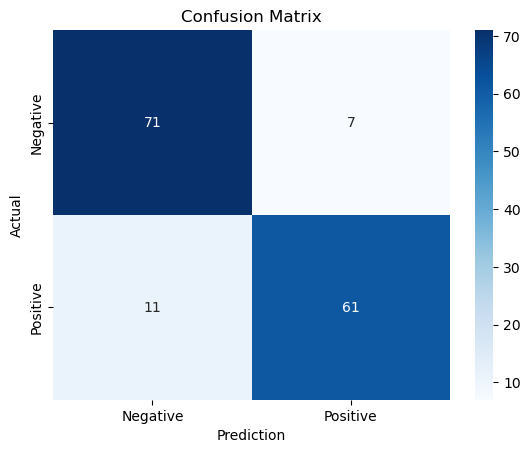

In [109]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




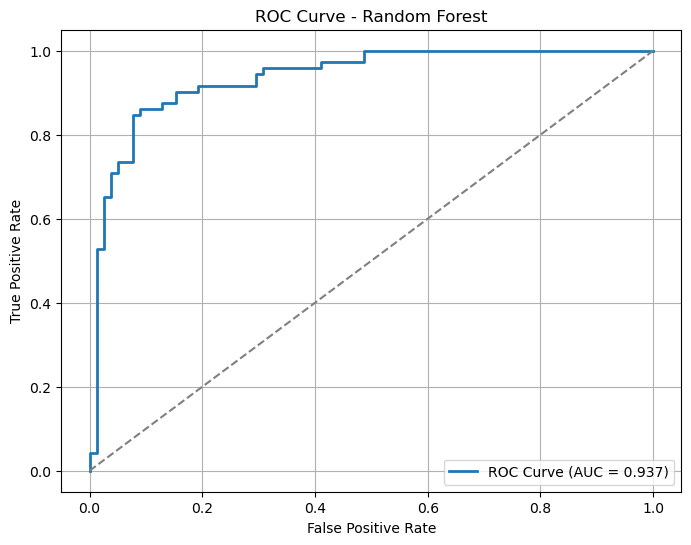

In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
auc_score = roc_auc_score(y_test, y_prob)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()